# Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### - Reading and preprocessing data

In [2]:
link_df = "Dataset1.xlsx"

In [3]:
df = pd.read_excel(link_df)
df.head()

,Num_escale,Num_Vehicule,Num_REMORQUE,Num_Client,Date_entrée,Heure_entrée,Date_sortie,Heure_sortie,Poids_chargé,Poids_vide,Pont_entrée,pont_Sortie,Produit
0,Escale105,Vehicule1,Remorque1,Client1,2020-01-02,08:48,2020-01-02,06:58,43220,15760,14,14.0,TRTX DE SOJA
1,Escale106,Vehicule2,Remorque2,Client1,2020-01-02,08:47,2020-01-02,07:00,42460,16480,17,17.0,PULPE DE BETTRAVE
2,Escale106,Vehicule3,Remorque3,Client1,2020-01-02,11:17,2020-01-02,07:02,42940,16600,17,17.0,PULPE DE BETTRAVE
3,Escale105,Vehicule4,Remorque4,Client1,2020-01-02,08:46,2020-01-02,07:03,42560,14700,14,14.0,TRTX DE SOJA
4,Escale106,Vehicule5,Remorque5,Client1,2020-01-02,10:05,2020-01-02,07:03,42020,16300,17,17.0,PULPE DE BETTRAVE


### - Handling missing values

In [4]:
pont_Sortie_missing_indices = df[df["pont_Sortie"].isna()]["Pont_entrée"].index

In [5]:
df["pont_Sortie"][pont_Sortie_missing_indices]=df["Pont_entrée"][pont_Sortie_missing_indices]

C:\Users\Ayoub\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
df=df.dropna()

### - Swap column names

In [7]:
df=df.rename(columns={'Heure_entrée': 'Heure_sortie', 'Heure_sortie':'Heure_entrée'})

In [8]:
cols = df.columns.tolist()

In [9]:
cols = ['Num_escale',
 'Num_Vehicule',
 'Num_REMORQUE',
 'Num_Client',
 'Date_entrée',
 'Heure_entrée',
 'Date_sortie',
 'Heure_sortie',
 'Poids_chargé',
 'Poids_vide',
 'Pont_entrée',
 'pont_Sortie',
 'Produit']

In [10]:
df=df[cols]

**1. Calcul du poids à vide (chauffeur inclut) minimale observée et l’analyse de la distribution**

In [11]:
P_vide = df.Poids_vide
P_vide.min()

3760

In [47]:
P_vide.describe()

count    70606.000000
mean     16120.716086
std        833.669475
min       3760.000000
25%      15620.000000
50%      16100.000000
75%      16620.000000
max      19960.000000
Name: Poids_vide, dtype: float64

C:\Users\Ayoub\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:59: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)


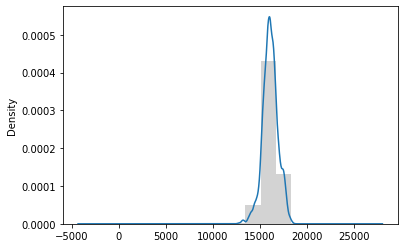

In [50]:
P_vide.plot(kind = "hist", normed = True, color = "lightgrey")
P_vide.plot(kind = "kde")

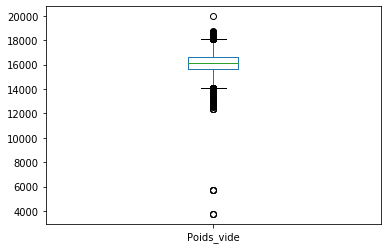

In [55]:
df.boxplot(column = "Poids_vide",grid=False)

In [48]:
import scipy.stats
scipy.stats.normaltest(P_vide)

NormaltestResult(statistic=8434.722841029095, pvalue=0.0)

In [49]:
scipy.stats.shapiro(P_vide)

C:\Users\Ayoub\anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9822229146957397, 0.0)

**2. Identifier l’écart type par couple véhicule / remorque**

In [13]:
newT = df.Poids_vide
couple1 = [df.Num_Vehicule, df.Num_REMORQUE]
newC = newT.groupby(couple1).std()
newC.head()

Num_Vehicule  Num_REMORQUE
Vehicule1     Remorque1       126.867559
              Remorque2001           NaN
              Remorque3214     70.710678
              Remorque3234     34.156503
Vehicule10    Remorque10      117.804953
Name: Poids_vide, dtype: float64

**3. Proposer un écart logique : *+ 150 kg de plus que poids minimal observé* : nous supposons que le chauffeur ne peut venir avec un réservoir vide mais avec un minimum de carburant pour rouler. Le plein maximal est de 400 kg**

In [14]:
std_by_rem = df.groupby(df.Num_REMORQUE).std().Poids_vide
std_by_rem.mean()

135.43425360226152

*On calcue le poids moyen des extensions, ce dernier vaut la déviation standard des poids_vide %num_remorque, on obtient alors 135,43 kg, on prend après 150kg, puis on aura:*

*l'écart logique = poids_minimal_observé + moyenne_extensions = 3760 + 150 =* **3910 kg**

__4. Proposer des classifications par écart-type : Exemple :__
    1. Liste noire : camions venant avec 2 fois écart type
    2. Liste rouge : camions venant avec 1 fois écart type
    3. Liste jaune : camions venant avec + 150 kg de plus que le poids à vide minima observée

In [15]:
écart_type = std_by_rem
print("L'écart type par Num_Remorque vaut: \n",écart_type)

L'écart type par Num_Remorque vaut: 
 Num_REMORQUE
Remorque1       127.833289
Remorque10      119.402573
Remorque100     219.553326
Remorque1000           NaN
Remorque1001     84.852814
                   ...    
Remorque995      82.342443
Remorque996     203.061095
Remorque997            NaN
Remorque998            NaN
Remorque999     113.137085
Name: Poids_vide, Length: 4189, dtype: float64


In [16]:
P_vide.describe()

count    70606.000000
mean     16120.716086
std        833.669475
min       3760.000000
25%      15620.000000
50%      16100.000000
75%      16620.000000
max      19960.000000
Name: Poids_vide, dtype: float64

In [17]:
min_by_rem = df.groupby("Num_REMORQUE").min().Poids_vide
min_by_rem

Num_REMORQUE
Remorque1       15360
Remorque10      15600
Remorque100     15540
Remorque1000    16380
Remorque1001    15840
                ...  
Remorque995     15060
Remorque996     15380
Remorque997     15920
Remorque998     14900
Remorque999     16040
Name: Poids_vide, Length: 4189, dtype: int64

In [18]:
noir = list()
rouge = list()
jaune = list()

for idx, line in df.iterrows():
    num_rem = line['Num_REMORQUE']
    deviation = line['Poids_vide'] - min_by_rem[num_rem]
    if isinstance(std_by_rem[num_rem], float):
        jaune.append(deviation > 150)
        rouge.append(deviation > std_by_rem[num_rem])
        noir.append(deviation > 2 * std_by_rem[num_rem])

C:\Users\Ayoub\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Ayoub\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


In [19]:
data = {"Liste noir": noir, "Liste rouge": rouge, "Liste jaune": jaune }
listes_df = pd.DataFrame.from_dict(data)
listes_df

,Liste noir,Liste rouge,Liste jaune
0,True,True,True
1,False,True,False
2,True,True,True
3,False,True,True
4,True,True,True
...,...,...,...
70601,False,True,True
70602,True,True,True
70603,False,False,False
70604,True,True,True


In [20]:
data_with_classes = pd.concat([df, listes_df], axis=1)
data_with_classes.head()

,Num_escale,Num_Vehicule,Num_REMORQUE,Num_Client,Date_entrée,Heure_entrée,Date_sortie,Heure_sortie,Poids_chargé,Poids_vide,Pont_entrée,pont_Sortie,Produit,Liste noir,Liste rouge,Liste jaune
0,Escale105,Vehicule1,Remorque1,Client1,2020-01-02,06:58,2020-01-02,08:48,43220.0,15760.0,14.0,14.0,TRTX DE SOJA,True,True,True
1,Escale106,Vehicule2,Remorque2,Client1,2020-01-02,07:00,2020-01-02,08:47,42460.0,16480.0,17.0,17.0,PULPE DE BETTRAVE,False,True,False
2,Escale106,Vehicule3,Remorque3,Client1,2020-01-02,07:02,2020-01-02,11:17,42940.0,16600.0,17.0,17.0,PULPE DE BETTRAVE,True,True,True
3,Escale105,Vehicule4,Remorque4,Client1,2020-01-02,07:03,2020-01-02,08:46,42560.0,14700.0,14.0,14.0,TRTX DE SOJA,False,True,True
4,Escale106,Vehicule5,Remorque5,Client1,2020-01-02,07:03,2020-01-02,10:05,42020.0,16300.0,17.0,17.0,PULPE DE BETTRAVE,True,True,True


__5. Temps d’attente entre le poids à vide et poids totalement chargé à la sortie__

In [21]:
data_with_time = data_with_classes.copy()

In [22]:
t1 = data_with_time["Date_entrée"].copy()
t2 = data_with_time["Date_sortie"].copy()

In [23]:
date_dep = np.datetime_as_string(t1, unit='D') + (" " + data_with_time['Heure_entrée'])
date_sor = np.datetime_as_string(t2, unit='D') + (" " + data_with_time['Heure_sortie'])

In [24]:
date_dep = pd.to_datetime(date_dep)
date_sor = pd.to_datetime(date_sor)

In [25]:
data_with_time['Temps_attente'] = np.abs(date_sor - date_dep)

In [26]:
data_with_time[['Date_entrée','Heure_entrée','Date_sortie','Heure_sortie','Temps_attente']].head(10)

,Date_entrée,Heure_entrée,Date_sortie,Heure_sortie,Temps_attente
0,2020-01-02,06:58,2020-01-02,08:48,01:50:00
1,2020-01-02,07:00,2020-01-02,08:47,01:47:00
2,2020-01-02,07:02,2020-01-02,11:17,04:15:00
3,2020-01-02,07:03,2020-01-02,08:46,01:43:00
4,2020-01-02,07:03,2020-01-02,10:05,03:02:00
5,2020-01-02,07:04,2020-01-02,10:22,03:18:00
6,2020-01-02,07:05,2020-01-02,09:27,02:22:00
7,2020-01-02,07:07,2020-01-02,09:07,02:00:00
8,2020-01-02,07:07,2020-01-02,09:28,02:21:00
9,2020-01-02,07:08,2020-01-02,09:42,02:34:00


In [27]:
data_with_time.Temps_attente.describe()

count                     70606
mean     0 days 07:27:15.604622
std      0 days 12:26:11.159075
min             0 days 00:00:00
25%             0 days 01:26:00
50%             0 days 02:36:00
75%             0 days 05:22:00
max             2 days 23:22:00
Name: Temps_attente, dtype: object

*On test selon liste [noir, rouge, jaune] et on attribue un risque par degré:*

In [115]:
def niveau_risque(list_donnee):
    if list_donnee[0] is True:
        return 3
    elif list_donnee[1] is True:
        return 2
    elif list_donnee[2] is True:
        return 1
    return 0

In [116]:
nouv_data = data_with_time
nouv_data['Degré_du_risque'] = [nouv_data['Liste noir'],nouv_data['Liste rouge'],nouv_data['Liste jaune']].apply(niveau_risque)

AttributeError: 'list' object has no attribute 'apply'

__6. Analyse selon la destination__

In [28]:
client_temps = data_with_time[['Num_Client','Temps_attente']]

In [29]:
#client_temps.groupby(client_temps.Num_Client).head()

In [30]:
clt = client_temps.Num_Client.unique()
moy_t = list()
for i in range(len(clt)):
    moy_t.append(client_temps[client_temps.Num_Client==clt[i]].mean()[0])

In [31]:
data_cm={
    'Client' : clt,
    'Moy_temps_attente' : moy_t
}

In [32]:
dfd = pd.DataFrame.from_dict(data_cm).dropna()
dfd

,Client,Moy_temps_attente
0,Client1,08:48:04.247830
1,Client2,05:53:21.443385
2,Client3,01:28:38.592233
3,Client4,02:02:59.150943
4,Client5,01:20:00
6,Client6,07:08:13.349633
7,Client7,06:45:54.268292
8,Client8,07:16:26.686585
9,Client9,02:12:45
10,Client10,09:04:51.561325


In [58]:
dfd=dfd.set_index('Client')

In [72]:
dfd.index

Index(['Client1', 'Client2', 'Client3', 'Client4', 'Client5', 'Client6',
       'Client7', 'Client8', 'Client9', 'Client10', 'Client11', 'Client12',
       'Client13', 'Client14', 'Client15', 'Client16', 'Client17', 'Client18',
       'Client19', 'Client20', 'Client21', 'Client22', 'Client23', 'Client24',
       'Client25', 'Client26'],
      dtype='object', name='Client')

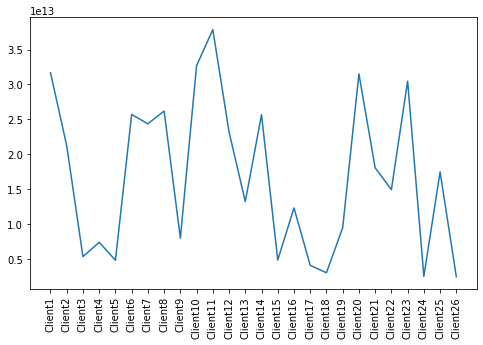

In [89]:
x=dfd.index;
fig = plt.figure(1, figsize=(8, 5));
plt.plot(x,dfd.Moy_temps_attente);
labels=x;
plt.xticks(x,labels, rotation='vertical');


__7. Analyse selon la matière première__

In [34]:
client_temps2 = data_with_time[['Produit','Temps_attente']]

In [35]:
clt2 = client_temps2.Produit.unique()
moy_t2 = list()
for i in range(len(clt2)):
    moy_t2.append(client_temps[client_temps2.Produit==clt2[i]].mean()[0])

In [36]:
data_cm2={
    'Produit' : clt2,
    'Moy_temps_attente' : moy_t2
}


In [37]:
dfd2 = pd.DataFrame.from_dict(data_cm2).dropna()
dfd2

,Produit,Moy_temps_attente
0,TRTX DE SOJA,10:35:24.092801
1,PULPE DE BETTRAVE,03:25:28.629080
2,TRTX SOJA,03:32:12.209302
3,ferraille,01:40:28.104089
4,SABLE,02:02:59.150943
5,DDGS,07:30:41.071287
6,SEL GEMME,01:20:00
7,SON DE BLE,03:25:48.926108
8,FERRAILLE,01:25:21.220268
10,huile brute de soja,08:43:28.199445


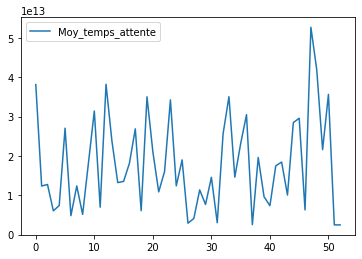

In [38]:
dfd2.plot.line()

__8. Pesage chez différent pont bascule : entrée par un pont bascule et sortie par un autre : les camions  se présentant dans des ponts différents sont-ils susceptibles de frauder ?__

__9. Analyse de saisonnalité :__
    1. Ecart par mois
    2. Ecart par Tranche horaire : Matin, après-midi, soir
    3. Période avant Covid (avant le 16 mars) et pendant Covid

__&ensp;&ensp;&ensp;9.1. Ecart par mois__

In [39]:
DF1 = data_with_time
DF1['month']=pd.DatetimeIndex(DF1["Date_entrée"]).month
DF1['hour']=pd.DatetimeIndex(DF1["Heure_entrée"]).hour

In [40]:
DF1.Temps_attente.groupby(by=[DF1.month]).sum()

month
1.0   2778 days 00:28:00
2.0   2325 days 02:38:00
3.0   3544 days 21:03:00
4.0   5893 days 21:48:00
5.0   5449 days 02:48:00
6.0   1939 days 00:00:00
Name: Temps_attente, dtype: timedelta64[ns]

__&ensp;&ensp;&ensp;9.2. Ecart par Tranche horaire : Matin, après-midi, soir__

In [41]:
#DF1.Temps_attente.groupby(by=[DF1.hour]).sum()

In [42]:
def apply_period(hour):
    if hour in range(4,12):
        return "Matin"
    elif hour in range(12,20):
        return "Après-Midi"
    else:
        return "Soir"

In [43]:
DF1['Période']=DF1['hour'].apply(apply_period)

In [44]:
DF1.Temps_attente.groupby(by=[DF1.Période]).sum()

Période
Après-Midi   7220 days 13:04:00
Matin        4777 days 02:09:00
Soir         9932 days 09:32:00
Name: Temps_attente, dtype: timedelta64[ns]

__&ensp;&ensp;&ensp;9.3. Période avant Covid (avant le 16 mars) et pendant Covid__

In [45]:
from datetime import datetime
DF1['Covid']=(date_dep).apply(lambda x: "Après" if (x > pd.to_datetime('2020-03-16 00:00:00')) else "Avant")

In [46]:
DF1.Temps_attente.groupby(by=[DF1['Covid']]).sum()

Covid
Après   15370 days 00:59:00
Avant    6559 days 23:46:00
Name: Temps_attente, dtype: timedelta64[ns]

__10. En faisant appel au technique d’apprentissage automatique, pourriez-vous classer les transporteurs par niveau de risque, afin de proposer des contrôles détaillés sur les transporteurs à risque.__